# PaleoAI Dataset Arithmetic

`paleoai_dataset_arithmetic.ipynb`

This notebook is for using pandas dataframes for elegantly adding or subtracting sets of data samples while maintaining unique-specimen constraints based on enforcing uniqueness for a user-specified id column. Using simple operator overloading in Python class definitions, we can perform complex queries with minimal boilerplate.

Author: Jacob A Rose  
Created on: Monday July 19th, 2021

## Top

In [4]:
file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/512/full/jpg" -type f
print(f"Found {len(file_list)} files")

Found 1520 files


In [18]:
file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/512/full/jpg" -type f
print(f"Found {len(file_list)} files")

Found 3320 files


In [ ]:
import os
from pathlib import Path

from lightning_hydra_classifiers.utils.dataset_management_utils import Extract as ExtractBase
from lightning_hydra_classifiers.utils.dataset_management_utils import DatasetFilePathParser, parse_df_catalog_from_image_directory

root_dir = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/512/full/jpg"

<Figure size 432x288 with 0 Axes>

(874, 1456)


<Figure size 432x288 with 0 Axes>

(3008, 2000)


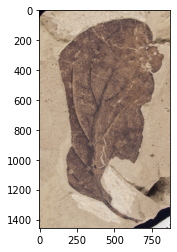

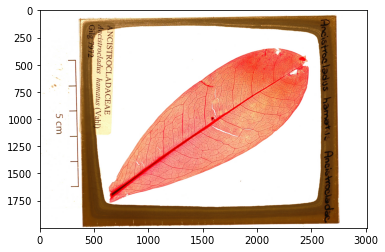

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import cv2, PIL
import matplotlib.pyplot as plt



v_img = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/original/full/jpg/Cornaceae/Cornaceae_Cornus_sp. RP62_General Fossils_DMNH-17685.jpg"
# v_img = cv2.imread(v_img)
v_img = PIL.Image.open(v_img)

h_img = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/original/full/jpg/Ancistrocladaceae/Ancistrocladaceae_Ancistrocladus_hamatus_Wolfe_Wolfe_7972.jpg"
# h_img = cv2.imread(h_img)
h_img = PIL.Image.open(h_img)

plt.figure(); plt.imshow(v_img)
print(v_img.size)
plt.figure(); plt.imshow(h_img)
print(h_img.size)

## imports & functions

In [1]:
%load_ext autoreload
%autoreload 2

from lightning_hydra_classifiers.data.utils.catalog_registry import *


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"
import torchvision, torch, time
from PIL import Image
from MapExtrackt import FeatureExtractor

from lightning_hydra_classifiers.data.utils.make_catalogs import *

import numpy as np
from rising.loading import DataLoader
from tqdm.notebook import trange, tqdm

from torchvision import transforms
import time

import copy
from rich import print as pp

In [2]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, monitor, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            monitor_update = 0
            
            for i, batch in tqdm(enumerate(dataloaders[phase]), total=len(dataloaders[phase]), desc=phase):
                x, y = batch[:2]
#                 x, y = x.cuda(non_blocking=pin_memory), y.cuda(non_blocking=pin_memory)
                x, y = x.to(device, non_blocking=pin_memory), y.to(device, non_blocking=pin_memory)

                if phase == "train":
                    monitor_update += 1
                    if monitor_update % 10 == 0:
                        monitor.start()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(x)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, y)
                                
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * x.shape[0]
                running_corrects += torch.sum(preds == y.data)
            if phase == 'train':
                scheduler.step()
                

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def visualize_model(model,
                    dataloaders,
                    class_names,
                    num_images=6,
                    pin_memory=True):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        
        st = time.time()
        for i, batch in tqdm(enumerate(dataloader['val']), total=len(dataloader)): #leave=False, position=1, total=len(dataloader)):
            x, y = batch[:2]
            x, y = x.cuda(non_blocking=pin_memory), y.cuda(non_blocking=pin_memory)
            
            outputs = model(x)
            _, preds = torch.max(outputs, 1)        
        
            for j in range(x.shape[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(toPIL(x.cpu()).data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    end_time = time.time() - st
                    return f"visualize_model()\nTotal duration: {end_time-st:.2f} seconds"
                
            model.train(mode=was_training)
            end_time = time.time() - st
            return f"visualize_model()\nTotal duration: {end_time-st:.2f} seconds"


## Import and preprocess datasets for training

In [3]:
from IPython.core.interactiveshell import InteractiveShell
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"
import os

if 'TOY_DATA_DIR' not in os.environ: 
    os.environ['TOY_DATA_DIR'] = "/media/data_cifs/projects/prj_fossils/data/toy_data"
        
default_root_dir = os.environ['TOY_DATA_DIR']
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)

from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark, \
                                            tensors_benchmark, paths_benchmark
import avalanche
import torch
import torchvision
from avalanche.benchmarks.datasets import MNIST, CIFAR10 #, FashionMNIST, KMNIST, EMNIST, \
# QMNIST, FakeData, CocoCaptions, CocoDetection, LSUN, ImageNet, , \

from avalanche.benchmarks.utils import AvalancheDataset
from lightning_hydra_classifiers.data.utils import make_catalogs
from lightning_hydra_classifiers.utils.common_utils import (LabelEncoder,
                                                            trainval_split,
                                                            trainvaltest_split,
                                                            plot_split_distributions,
                                                            plot_class_distributions)
import torchdata
from lightning_hydra_classifiers.data.utils.make_catalogs import *


# from lightning_hydra_classifiers.data.utils.catalog_registry import *
from rich import print as pp
# available = available_datasets()
# pp(available.tags)
from torchvision import transforms
from typing import *

In [4]:
# experiment_dir = Path("/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/experiments_August_2021/Extant-to-PNAS-512-transfer_benchmark")
# task_0_dir = experiment_dir / "task_0"
# task_1_dir = experiment_dir / "task_1"
# task_0, task_1 = {}, {}

# for subset in ["train","val","test"]:
#     task_0[subset], _ = CSVDatasetConfig.import_dataset_state(config_path = task_0_dir / f"{subset}.yaml")
#     task_1[subset], _ = CSVDatasetConfig.import_dataset_state(config_path = task_1_dir / f"{subset}.yaml")

# task_0["train"][0][0]
# task_0["val"][0][0]
# task_0["test"][0][0]

# task_1["train"][0][0]
# task_1["val"][0][0]
# task_1["test"][0][0]

### Create transforms

In [5]:

totensor: Callable = torchvision.transforms.ToTensor()

def toPIL(img: torch.Tensor, mode="RGB") -> Callable:
    return torchvision.transforms.ToPILImage(mode)(img)


def normalize_transform(mean = [0.485, 0.456, 0.406],
                        std = [0.229, 0.224, 0.225]) -> Callable:
    return transforms.Normalize(mean=mean,
                                std=std)

def default_train_transforms(image_size: int=224,
                             normalize: bool=True, 
                             augment:bool=True,
                             grayscale: bool=True,
                             channels: Optional[int]=3,
                             mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225]):
    """Subclasses can override this or user can provide custom transforms at runtime"""
    transform_list = []
#         transform_jit_list = []
    resize_PIL = not augment
    if augment:
        transform_list.extend([transforms.RandomResizedCrop(size=image_size,
                                                            scale=(0.25, 1.2),
                                                            ratio=(0.7, 1.3),
                                                            interpolation=2),
                               totensor
                             ])
    return default_eval_transforms(image_size=image_size,
                                        normalize=normalize,
                                        resize_PIL=resize_PIL,
                                        grayscale=grayscale,
                                        channels=channels,
                                        transform_list=transform_list,
                                        mean=mean,
                                        std=std)

def default_eval_transforms(image_size: int=224,
                            image_buffer_size: int=32,
                            normalize: bool=True,
                            resize_PIL: bool=True,
                            grayscale: bool=True,
                            channels: Optional[int]=3,
                            transform_list: Optional[List[Callable]]=None,
                            mean = [0.485, 0.456, 0.406],
                            std = [0.229, 0.224, 0.225]):
    """Subclasses can override this or user can provide custom transforms at runtime"""
    transform_list = transform_list or []
    transform_jit_list = []

    if resize_PIL:
        # if True, assumes input images are PIL.Images (But need to check if this even matters.)
        # if False, expects input images to already be torch.Tensors
        transform_list.extend([transforms.Resize(image_size+image_buffer_size),
                               transforms.CenterCrop(image_size),
                               totensor])
    if normalize:
        transform_jit_list.append(normalize_transform(mean, std))

    if grayscale:
        transform_jit_list.append(transforms.Grayscale(num_output_channels=channels))

    return transforms.Compose([*transform_list, *transform_jit_list])
        
        
#     selector = [transforms.Lambda(lambda x: (x[0], x[1]))]
#     return transforms.Compose([*transform_list, *transform_jit_list, *selector])


def get_default_transforms(image_size: int=224,
                           normalize: bool=True,
                           augment:bool=True,
                           grayscale: bool=True,
                           channels: Optional[int]=3,
                           mean = [0.485, 0.456, 0.406],
                           std = [0.229, 0.224, 0.225]):

    
    train_transform = default_train_transforms(image_size=image_size,
                                               normalize=normalize,
                                               augment=augment,
                                               grayscale=grayscale,
                                               channels=channels,
                                               mean=mean,
                                               std=std)
    eval_transform = default_eval_transforms(image_size=image_size,
                                             image_buffer_size=32,
                                             normalize=normalize,
                                             resize_PIL=True, #not augment,
                                             grayscale=grayscale,
                                             channels=channels,
                                             transform_list=None,
                                             mean=mean,
                                             std=std)
    
    
    
    return train_transform, eval_transform

train_transform, val_transform = get_default_transforms(image_size=224,
                                                         normalize=True,
                                                         augment=True,
                                                         grayscale=True,
                                                         channels=3,
                                                         mean = [0.485, 0.456, 0.406],
                                                         std = [0.229, 0.224, 0.225])

### Assemble Avalanche Datasets for task 0 and task 1

In [7]:
experiment_dir = Path("/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/experiments_August_2021/Extant-to-PNAS-512-transfer_benchmark")
task_0_dir = experiment_dir / "task_0"
task_1_dir = experiment_dir / "task_1"
task_0, task_1 = {}, {}

for subset in ["train","val","test"]:
    task_0[subset], _ = CSVDatasetConfig.import_dataset_state(config_path = task_0_dir / f"{subset}.yaml")
    task_1[subset], _ = CSVDatasetConfig.import_dataset_state(config_path = task_1_dir / f"{subset}.yaml")

# task_0["train"][0][0]
# task_0["val"][0][0]
# task_0["test"][0][0]

# task_1["train"][0][0]
# task_1["val"][0][0]
# task_1["test"][0][0]

2021-08-19 09:57:20,944 lightning_hydra_classifiers.utils.common_utils INFO     LabelEncoder replacing 1 class encodings with that other an another class
2021-08-19 09:57:20,945 lightning_hydra_classifiers.utils.common_utils INFO     Replacing: {'Nothofagaceae': 'Fagaceae'}


encoding all targets


2021-08-19 09:57:31,612 lightning_hydra_classifiers.utils.common_utils INFO     LabelEncoder replacing 1 class encodings with that other an another class
2021-08-19 09:57:31,615 lightning_hydra_classifiers.utils.common_utils INFO     Replacing: {'Nothofagaceae': 'Fagaceae'}


encoding all targets
encoding all targets


2021-08-19 09:57:32,814 lightning_hydra_classifiers.utils.common_utils INFO     LabelEncoder replacing 1 class encodings with that other an another class
2021-08-19 09:57:32,815 lightning_hydra_classifiers.utils.common_utils INFO     Replacing: {'Nothofagaceae': 'Fagaceae'}


encoding all targets
encoding all targets


2021-08-19 09:57:35,420 lightning_hydra_classifiers.utils.common_utils INFO     LabelEncoder replacing 1 class encodings with that other an another class
2021-08-19 09:57:35,421 lightning_hydra_classifiers.utils.common_utils INFO     Replacing: {'Nothofagaceae': 'Fagaceae'}


encoding all targets
encoding all targets


2021-08-19 09:57:35,747 lightning_hydra_classifiers.utils.common_utils INFO     LabelEncoder replacing 1 class encodings with that other an another class
2021-08-19 09:57:35,747 lightning_hydra_classifiers.utils.common_utils INFO     Replacing: {'Nothofagaceae': 'Fagaceae'}


encoding all targets
encoding all targets


2021-08-19 09:57:37,360 lightning_hydra_classifiers.utils.common_utils INFO     LabelEncoder replacing 1 class encodings with that other an another class
2021-08-19 09:57:37,361 lightning_hydra_classifiers.utils.common_utils INFO     Replacing: {'Nothofagaceae': 'Fagaceae'}


encoding all targets
encoding all targets
encoding all targets


In [8]:
avalanche_tasks = {0: {},
                   1: {}}

transforms = {"train":train_transform,
              "val": val_transform,
              "test": val_transform}

for subset in ['train','val','test']:
    avalanche_tasks[0][subset] = AvalancheDataset(task_0[subset], task_labels=0, transform=transforms[subset])
    avalanche_tasks[1][subset] = AvalancheDataset(task_1[subset], task_labels=1, transform=transforms[subset])


In [9]:
avalanche_tasks

{0: {'train': <avalanche.benchmarks.utils.avalanche_dataset.AvalancheDataset at 0x7f7d452ae430>,
  'val': <avalanche.benchmarks.utils.avalanche_dataset.AvalancheDataset at 0x7f7d452aefa0>,
  'test': <avalanche.benchmarks.utils.avalanche_dataset.AvalancheDataset at 0x7f7d45ae4520>},
 1: {'train': <avalanche.benchmarks.utils.avalanche_dataset.AvalancheDataset at 0x7f7d452ae6a0>,
  'val': <avalanche.benchmarks.utils.avalanche_dataset.AvalancheDataset at 0x7f7d45ae4460>,
  'test': <avalanche.benchmarks.utils.avalanche_dataset.AvalancheDataset at 0x7f7d45ae46a0>}}

In [10]:
from avalanche.benchmarks.generators import dataset_benchmark



scenario = dataset_benchmark([avalanche_tasks[0]["train"], avalanche_tasks[1]["train"]],
                             [avalanche_tasks[0]["val"], avalanche_tasks[1]["val"]])#,
#                              train_transform=train_transform,
#                              eval_transform=eval_transform)

# Model training

In [11]:
import logging
import os
from pathlib import Path
from typing import Union, Callable, Tuple, Optional, Dict, Any, List

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
# from torchvision.datasets.utils import download_and_extract_archive

import pytorch_lightning as pl
from pl_examples import cli_lightning_logo
from pytorch_lightning import LightningDataModule
from pytorch_lightning.callbacks.finetuning import BaseFinetuning
from pytorch_lightning.utilities import rank_zero_info
from pytorch_lightning import seed_everything
from pytorch_lightning.utilities.cli import LightningCLI


from lightning_hydra_classifiers.models import heads, base
from lightning_hydra_classifiers.models.base import BaseLightningModule

from lightning_hydra_classifiers.models.heads.classifier import Classifier


log = logging.getLogger(__name__)
# DATA_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"

#  --- Finetuning Callback ---

class TransferLearningModel(BaseLightningModule):

    classifier_factory: Callable = heads.Classifier

    def __init__(
                 self,
                 classifier: heads.Classifier=None,
                 train_bn: bool = False,
                 milestones: tuple = (2, 4, 8),
                 batch_size: int = 32,
                 optimizer: str = "Adam",
                 lr: float = 1e-3,
                 lr_scheduler_gamma: float = 1e-1,
                 classifier_kwargs: Optional[Dict[str, Any]]=None,
#                  num_workers: int = 6,
                 **kwargs
                 ) -> None:
        """TransferLearningModel
        Args:
            classifier: heads.Classifier instance (subclass of nn.Module) containing 3 named children:
                1. backbone
                2. bottleneck
                3. head
            train_bn: Whether the BatchNorm layers should be trainable. Defaults to False.
            milestones: List of two epochs milestones at which to update the trainable layers
            optimizer: str
                Name of optimizer to use.
            lr: Initial learning rate
            lr_scheduler_gamma: Factor by which the learning rate is reduced at each milestone
        """
        super().__init__()
        self.classifier = classifier
        self.classifier_kwargs = classifier_kwargs or {}
        if classifier is None:
            self.num_classes = self.classifier_kwargs['num_classes']
        else:
            self.num_classes = classifier.num_classes
        
        self.train_bn = train_bn
        self.milestones = milestones
        self.batch_size = batch_size
        self.lr = lr
        self.lr_scheduler_gamma = lr_scheduler_gamma
        self.optimizer_func = getattr(optim, optimizer)

        self._build_classifier()
        self._init_metrics('all')

#         self.save_hyperparameters()

    def _build_classifier(self):
        """Define model layers & loss."""
        if self.classifier is None:
            self.classifier = self.classifier_factory(**self.classifier_kwargs)
        self.feature_extractor = self.classifier.backbone
    
        self.fc = self.classifier.head        
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        """Forward pass. Returns logits."""
        x = self.classifier(x)
        return x

    def loss(self, logits, labels):
        return self.criterion(logits, labels)

    def probs(self, x):
        return x.softmax(dim=-1)
    
    def configure_optimizers(self):
        parameters = list(self.parameters())
        trainable_parameters = list(filter(lambda p: p.requires_grad, parameters))
        rank_zero_info(
            f"The model will start training with only {len(trainable_parameters)} "
            f"trainable parameters out of {len(parameters)}."
        )
        log.info(f"self.lr={self.lr}")
        optimizer = self.optimizer_func(trainable_parameters, lr=self.lr)
        scheduler = MultiStepLR(optimizer, milestones=self.milestones, gamma=self.lr_scheduler_gamma)
        return [optimizer], [scheduler]

In [12]:

classifier_kwargs = {"num_classes" : 19,
                     "backbone_name": 'resnet50',
                     "pretrained": True,
                     "bottleneck_dim": -1,
                     "finetune": True}

model = TransferLearningModel(train_bn = False,
                              milestones = (2, 4, 8),
                              batch_size = 32,
                              optimizer = "Adam",
                              lr = 1e-3,
                              lr_scheduler_gamma = 1e-1,
                              classifier_kwargs=classifier_kwargs)

Classifier: ['__class__', 'backbone', 'backbone_name', 'bottleneck', 'bottleneck_dim', 'finetune', 'head', 'kwargs', 'num_classes', 'pretrained', 'self']


In [15]:
dir(avalanche_tasks[0]['train'])

['__abstractmethods__',
 '__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_groups_from_original_dataset',
 '_add_original_dataset_group',
 '_apply_transforms',
 '_borrow_transformations',
 '_check_groups_dict_format',
 '_dataset',
 '_flatten_dataset',
 '_fork_dataset',
 '_freeze_dataset_group',
 '_freeze_original_dataset',
 '_frozen_transforms',
 '_get_single_item',
 '_has_own_transformations',
 '_initialize_collate_fn',
 '_initialize_groups_dict',
 '_initialize_targets_sequence',
 '_initialize_task_labels_s

In [19]:
img = avalanche_tasks[0]['train'][0][0]

In [22]:
from MapExtrackt import FeatureExtractor
from PIL import Image


dark_img_path = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Extant_Leaves/Annonaceae/Annonaceae_Anaxagorea_acuminata_Wing_Wing_132-001.jpg"

fe = FeatureExtractor(model.classifier.cpu())

In [6]:
import numpy as np
import cv2
import torch, torchvision
img = cv2.imread(dark_img_path)
img = torchvision.transforms.RandomResizedCrop(224)(torch.from_numpy(img).permute(2,0,1)).permute(1,2,0).numpy()
# torch.from_numpy()
# img.shape

In [24]:

fe.set_image(img.numpy())

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 224, 3, 224] to have 3 channels, but got 224 channels instead

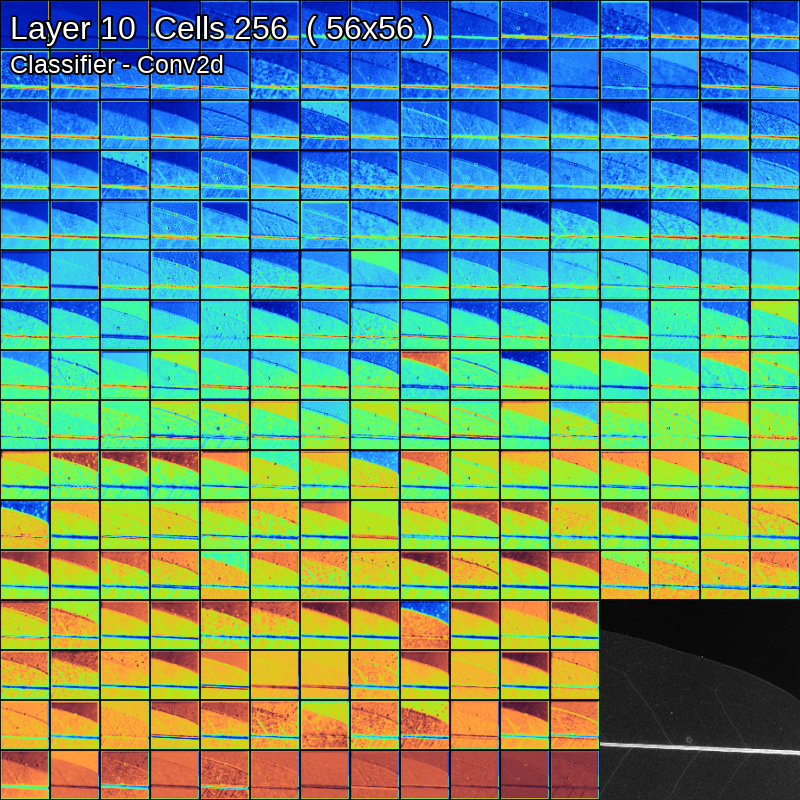

In [7]:
fe.display_from_map(layer_no=10,outsize=(800,800))

In [3]:
model

TransferLearningModel(
  (classifier): Classifier(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          

In [33]:
# scenario = dataset_benchmark([train_task0, train_task1],
#                              [val_task0, val_task1],
#                             train_transform=train_transform,
#                             eval_transform=eval_transform)

# train_task0 = AvalancheDataset(A_minus_B_data_splits['train'], task_labels=0)#, transform=train_transform)
# val_task0 = AvalancheDataset(A_minus_B_data_splits['val'], task_labels=0) #, transform=eval_transform)
# test_task0 = AvalancheDataset(A_minus_B_data_splits['test'], task_labels=0) #, transform=eval_transform)

# #########################################

# train_task1 = AvalancheDataset(B_minus_A_data_splits['train'], task_labels=1) #, transform=train_transform)
# val_task1 = AvalancheDataset(B_minus_A_data_splits['val'], task_labels=1) #, transform=eval_transform)
# test_task1 = AvalancheDataset(B_minus_A_data_splits['test'], task_labels=1) #, transform=eval_transform)

# toPIL(avalanche_tasks[0]["train"][0][0])
# toPIL(avalanche_tasks[0]["val"][0][0])
# toPIL(avalanche_tasks[0]["test"][0][0])

# toPIL(avalanche_tasks[1]["train"][0][0])
# toPIL(avalanche_tasks[1]["val"][0][0])
# toPIL(avalanche_tasks[1]["test"][0][0])

# Scratch

In [30]:
# len(scenario.train_stream[0].classes_in_this_experience)
# len(scenario.train_stream[1].classes_in_this_experience)
# scenario.train_stream[1].origin_stream.name == scenario.train_stream[0].origin_stream.name
# # scenario.train_stream.name
# dir(scenario.train_stream[1].dataset)
# scenario.train_stream[1].dataset.transform

import torchvision
totensor: Callable = torchvision.transforms.ToTensor()

import torch
import numpy as np

# scenario.train_stream[1].dataset[0][0].numpy().shape
np.mean(scenario.train_stream[1].dataset[0][0].numpy()[0,...])
np.mean(scenario.train_stream[1].dataset[0][0].numpy()[1,...])
np.mean(scenario.train_stream[1].dataset[0][0].numpy()[2,...])
torch.std(scenario.train_stream[1].dataset[0][0])

### Creating a Benchmark (from Docs)

In [130]:
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark

from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop

train_task1[0]

# train_task1, val_task1, test_task1

scenario = ni_benchmark(
    train_task1, val_task1, n_experiences=2, shuffle=True, seed=1234)

train_stream = scenario.train_stream

for experience in train_stream:
    t = experience.task_label
    exp_id = experience.current_experience
    training_dataset = experience.dataset
    print('Task {} batch {} -> train'.format(t, exp_id))
    print('This batch contains', len(training_dataset), 'patterns')



train_transform = Compose([
    RandomCrop(28, padding=4),
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

test_transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

mnist_train = MNIST(
    default_root_dir, train=True, download=True, transform=train_transform
)
mnist_test = MNIST(
    default_root_dir, train=False, download=True, transform=test_transform
)

scenario = ni_benchmark(
    mnist_train, mnist_test, n_experiences=10, shuffle=True, seed=1234,
    balance_experiences=True
)
train_stream = scenario.train_stream
for experience in train_stream:
    t = experience.task_label
    exp_id = experience.current_experience
    training_dataset = experience.dataset
    print('Task {} batch {} -> train'.format(t, exp_id))
    print('This batch contains', len(training_dataset), 'patterns')

dir(scenario) #.train_stream)

scenario.n_classes
scenario.n_experiences
scenario.n_patterns_per_class
scenario.n_patterns_per_experience

len(scenario.original_train_dataset)
scenario.get_classes_timeline(0)

dir(training_dataset)

len(training_dataset.task_set[0])

from avalanche.benchmarks.generators import dataset_benchmark # , filelist_benchmark

dataset_benchmark(train_task1, val_task1, test_task1)

# train_cifar10_task1 = AvalancheDataset(train_cifar10, task_labels=1)
# test_cifar10_task1 = AvalancheDataset(test_cifar10, task_labels=1)

scenario_custom_task_labels = dataset_benchmark(
    [train_MNIST_task0, train_cifar10_task1],
    [test_MNIST_task0, test_cifar10_task1]
)

print('Without custom task labels:',
      generic_scenario.train_stream[1].task_label)

print('With custom task labels:',
      scenario_custom_task_labels.train_stream[1].task_label)

In [ ]:
# def left_union(data_df: pd.DataFrame, other_df: pd.DataFrame, id_col: str="catalog_number", suffixes=("_x", "_y")) -> pd.DataFrame:
#     """
#     Return a new dataframe containing all rows from `data_df`, concatenated with any rows that only exist in `other_df`. Any rows that are shared between the 2 default to only including the values from `data_df`.
    
#     """
#     return data_df.merge(other_df, how='outer', on=id_col, suffixes=suffixes)

import pandas as pd


def intersection(data_df: pd.DataFrame, other_df: pd.DataFrame, id_col: str="catalog_number", suffixes=("_x", "_y")) -> pd.DataFrame:
    """
    Return a new dataframe containing only rows that share the same values for `id_col` between `data_df` and `other_df`
    
    Equivalent to an AND join between sets
    """
    return data_df.merge(other_df, how='inner', on=id_col, suffixes=suffixes)


def left_exclusive(data_df: pd.DataFrame, other_df: pd.DataFrame, id_col: str="catalog_number") -> pd.DataFrame:
    """
    Return a new dataframe containing only rows from `data_df` that do not share an `id_col` value with any row from `other_df`.
    
    Equivalent to subtracting the set of `id_col` values in `other_df` from `data_df`
    """
    omit = list(other_df[id_col].values)
    
    return data_df[data_df[id_col].apply(lambda x: x not in omit)]

# extant_df = pd.read_csv("/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Extant-dataset_leavesdb-v0_3.csv", index_col=0)#  pnas_train = pd.read_csv("/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100/train.csv")# # pnas_test = pd.read_csv("/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100/test.csv"# 
# pnas_df = pd.concat([pnas_train, pnas_test]# 

# extant_in_pnas = intersection(data_df=extant# f,
#                               other_df=pna# df,
#                               id_col="catalog_nu# er",
#                               suffixes=("_extant", "_p# s"))

# # In order to only keep origina# columns
# suffixes=("_extant"# "_pnas")
# extant_in_pnas = extant_in_pnas.drop(columns = [c for c in extant_in_pnas.columns if c.endswith(suf# xes[1])])
# extant_in_pnas = extant_in_pnas.rename(columns = {c:c.split(suffixes[0])[0] for c in extant_in_pnas.columns})

# # extant_minus_pnas -> rows exclusive to extant dataset
# extant_minus_pnas = left_exclusive(data_df=extant_df,
#                                    other_df=pnas_df,
#                                    id_col="catalog_number",
#                                    suffixes=("_extant", "_pnas"))

# # pnas_minus_extant -> rows exclusive to pnas dataset
# pnas_minus_extant = left_exclusive(data_df=pnas_df,
#                                    other_df=extant_df,
#                                    id_col="catalog_number",
#                                    suffixes=("_pnas", "_extant"))

# extant_minus_pnas = left_exclusive(data_df=extant_df, other_df=pnas_df, id_col="catalog_number", suffixes=("_extant", "_pnas"))

# pnas_minus_extant = left_exclusive(data_df=pnas_df, other_df=extant_df, id_col="catalog_number", suffixes=("_pnas", "_extant"))

# extant_and_pnas = left_union(data_df=extant_df, other_df=pnas_df, id_col="catalog_number", suffixes=("_extant", "_pnas"))

## Code

In [ ]:
import pandas as pd


path = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_10_train.csv"

df = pd.read_csv(path, index_col=0)
df

import logging
import os.path
 
def initialize_logger():
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
     
    # create console handler and set level to info
    handler = logging.StreamHandler()
    handler.setLevel(logging.INFO)
    formatter = logging.Formatter("%(levelname)s - %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)

initialize_logger()

import torchdata
from typing import Union, List, Any, Tuple
# from collections import Counter
from lightning_hydra_classifiers.utils import template_utils
from lightning_hydra_classifiers.utils.common_utils import trainvaltest_split
import collections
from omegaconf import OmegaConf, DictConfig
from lightning_hydra_classifiers.data.common import CommonDataSelect, CommonDataset, LeavesLightningDataModule
from lightning_hydra_classifiers.data import fossil, extant, pnas
from rich import print as pp
import os

from typing import *
from pathlib import Path
import matplotlib.pyplot as plt

from IPython.display import display

log = template_utils.get_logger(__name__, level=logging.DEBUG)
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)




config_dir = "/media/data/jacob/GitHub/lightning-hydra-classifiers/configs"

from hydra.experimental import compose, initialize, initialize_config_dir
from omegaconf import OmegaConf, DictConfig
os.chdir(config_dir)
print(f"cwd = {os.getcwd()}")

def initialize_config(config_dir: str,
                      overrides=None):
    with initialize_config_dir(config_dir=config_dir, job_name="multi-gpu_experiment"):

        cfg = compose(config_name="multi-gpu", overrides=overrides)
        OmegaConf.set_struct(cfg, False)
        return cfg

y_col = 'family'
seed = 5687
val_train_split = 0.2

# pnas_name = "PNAS_family_100_512"
# extant_name = "Extant_family_10_512"

pnas_name = "PNAS_family_100_1024"#512"
extant_name = "Extant_family_10_1024" #512"


## Load primary Extant and PNAS datamodules
pnas_cfg = initialize_config(config_dir=config_dir,
                        overrides=["dataset=pnas_dataset",
                                  "datamodule=standalone_datamodule"])
# pnas_cfg[f"dataset.config.name"] = pnas_name

pnas_cfg.datamodule.config.dataset.name = pnas_name
pp(OmegaConf.to_container(pnas_cfg, resolve=False))

pnas_datamodule = LeavesLightningDataModule(pnas_cfg)#.datamodule.config)



extant_cfg = initialize_config(config_dir=config_dir,
                        overrides=["dataset=extant_dataset",
                                   "datamodule=standalone_datamodule"])
# pnas_cfg[f"dataset.config.name"] = pnas_name

extant_cfg.datamodule.config.dataset.name = extant_name
extant_datamodule = LeavesLightningDataModule(extant_cfg) #.datamodule.config)



In [ ]:
from lightning_hydra_classifiers.utils.common_utils import LabelEncoder, trainval_split
from lightning_hydra_classifiers.data.common import CommonDataset, LeavesLightningDataModule, plot_split_distributions
# default_config = initialize_config(config_dir=config_dir,
#                                    overrides=["datamodule=default_datamodule"])
# config = DictConfig({"datamodule.dataset.name":"Extant_family_10_minus_PNAS_family_100_512"})
# default_config = DictConfig({'datamodule':LeavesLightningDataModule.default_config()})

# pp(OmegaConf.to_container(datamodule.datamodule_config, resolve=True))
# default_config = DictConfig({'datamodule':LeavesLightningDataModule.default_config()})
# user_config = DictConfig({"datamodule":
#                               {"dataset":
#                                    {"name":"Extant_family_10_minus_PNAS_family_100_512"}
#                               }
#                          })
# pp(OmegaConf.to_container(OmegaConf.merge(default_config, user_config), resolve=True))

output_dir = "/media/data/jacob/GitHub/prj_fossils_contrastive/notebooks/Extant_family_10_1024_minus_PNAS_family_100_1024"

#         config = DictConfig({"dataset":
#                                        {"name":"Extant_family_10_minus_PNAS_family_100_512"}
#                             })
# config.dataset.config.name = "Extant_family_10_1024_in_PNAS_family_100_1024"
datamodule = LeavesLightningDataModule(config=None, #config, #default_config,
                                       data_dir=output_dir)
config.hparams.classes = datamodule.classes
config.hparams.num_classes = len(config.hparams.classes)
config.dataset.config.classes = datamodule.classes
config.dataset.config.num_classes = len(config.hparams.classes)


data_loader = datamodule.data_loader





